### Welcome!!!

My name is Kesava Kumar Reddy, and here is my implementation method of the Image Quality Detection. Here, I used Convolutional Neural Nets (CNNs) because they can be easy to train than normal neural nets. 

In [47]:
!wget "http://mklab.iti.gr/files/imageblur/CERTH_ImageBlurDataset.zip"

--2022-04-04 01:10:38--  http://mklab.iti.gr/files/imageblur/CERTH_ImageBlurDataset.zip
Resolving mklab.iti.gr (mklab.iti.gr)... 160.40.50.223
Connecting to mklab.iti.gr (mklab.iti.gr)|160.40.50.223|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mklab.iti.gr/files/imageblur/CERTH_ImageBlurDataset.zip [following]
--2022-04-04 01:10:39--  https://mklab.iti.gr/files/imageblur/CERTH_ImageBlurDataset.zip
Connecting to mklab.iti.gr (mklab.iti.gr)|160.40.50.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4022804823 (3.7G) [application/zip]
Saving to: ‘CERTH_ImageBlurDataset.zip.1’

RTH_ImageBlurDatase  14%[=>                  ] 571.29M  13.5MB/s    eta 5m 17s ^C


Filepaths must be changed here in the next 2 cells to respective folders containing the dataset

In [48]:
!unzip "/content/CERTH_ImageBlurDataset.zip"

Archive:  /content/CERTH_ImageBlurDataset.zip
replace CERTH_ImageBlurDataset/EvaluationSet/DigitalBlurSet/DiskR10_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [49]:
!unrar x "/content/CERTH_ImageBlurDataset/TrainingSet/NewDigitalBlur.rar" -o "/content/CERTH_ImageBlurDataset/TrainingSet"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/CERTH_ImageBlurDataset/TrainingSet/NewDigitalBlur.rar


Would you like to replace the existing file /content/CERTH_ImageBlurDataset/TrainingSet/NewDigitalBlur/ DiskR20_10.jpg
155847 bytes, modified on 2013-10-02 23:21
with a new one
155847 bytes, modified on 2013-10-02 23:21

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


Next 2 cells are about importing the required libraries for implementing our classifier

In [50]:
!pip install "torchmetrics" "matplotlib" "torch" "seaborn" "transformers" "opencv-python" "imutils" "torchvision" "Pillow" "tensorflow"

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 128, in resolve
    requirements, max_rounds=try_to_avoid_resolution_too_deep
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 366, in resolve
    name = min(unsatisfied_names, key=self._get_preference)
  File "/u

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
import os
from PIL import Image
from sklearn.model_selection import train_test_split

%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In this implementation, I use PyTorch framework so that the code can be easily implemented if using a GPU or TPU. The next cell is basically a test to see how the dataset looks. You can ignore this cell as it is basically for me to understand what images are defined as blurred.

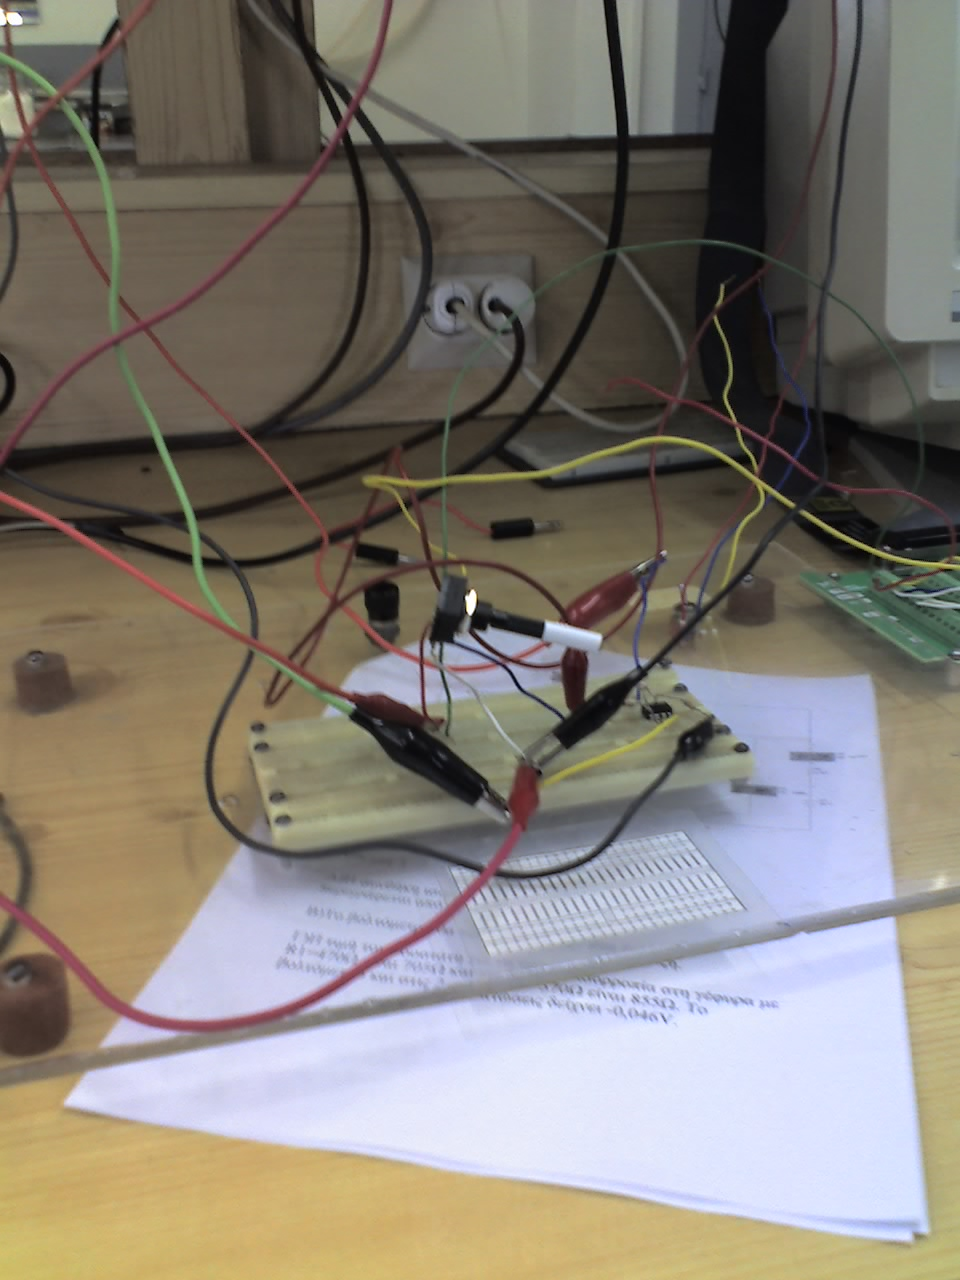

In [52]:
path1 = "/content/CERTH_ImageBlurDataset/TrainingSet/Artificially-Blurred/DiskR10_100_1830.jpg"
path2 = "/content/CERTH_ImageBlurDataset/TrainingSet/NewDigitalBlur/ DiskR8_26.jpg"
path3 = "/content/CERTH_ImageBlurDataset/TrainingSet/NewDigitalBlur/ GaussianH1x50S250_27.jpg"
path4 = "/content/CERTH_ImageBlurDataset/TrainingSet/NewDigitalBlur/ MotionL60H45_22.jpg"
path5 = "/content/CERTH_ImageBlurDataset/TrainingSet/Undistorted/CIMG0064.JPG"
path6 = "/content/CERTH_ImageBlurDataset/TrainingSet/Undistorted/DSCN0340.JPG"
path7 = "/content/CERTH_ImageBlurDataset/TrainingSet/Undistorted/P1011979.JPG"
path8 = "/content/CERTH_ImageBlurDataset/EvaluationSet/NaturalBlurSet/Original_4.jpg"
img  = cv2.imread(path8,cv2.IMREAD_COLOR)
cv2_imshow(img)

In [53]:
cv2.destroyAllWindows()

The DataPreprocess class is used to convert all the given image data into some sort of organized data. After using this class we can extract both the training and test/validation data into 2 DataFrame objects both containg the filepath of an image and whether it is blurry or not blurry.

Don't forget to change the filepath according to the location in your system

In [54]:
class DataPreprocess():
  def __init__(self):
    self.commontrain = "/content/CERTH_ImageBlurDataset/TrainingSet"
    self.commontest = "/content/CERTH_ImageBlurDataset/EvaluationSet"
    self.traindf = pd.DataFrame(columns=["Filepath","Result"])
    self.testdf = pd.DataFrame(columns = ["Filepath","Result"])
  
  def getDataframe(self):
    with os.scandir(self.commontrain) as entries1:
      for entry1 in entries1:
        if entry1.is_dir():
          if(entry1.name == "Undistorted"):
            with os.scandir(self.commontrain+"/"+entry1.name) as entries2:
              for entry2 in entries2:
                if entry2.is_file():
                  data = {"Filepath" : self.commontrain+"/"+entry1.name+"/"+entry2.name , "Result" : 0}
                  p = pd.DataFrame(data,index = [0])
                  self.traindf = pd.concat([self.traindf,p], ignore_index = True, names = ["Filepath","Result"])
          else:
            with os.scandir(self.commontrain+"/"+entry1.name) as entries3:
              for entry2 in entries3:
                if entry2.is_file():
                  data = {"Filepath" : self.commontrain+"/"+entry1.name+"/"+entry2.name , "Result" : 1}
                  p = pd.DataFrame(data,index = [0])
                  self.traindf = pd.concat([self.traindf,p], ignore_index = True, names = ["Filepath","Result"])
    return self.traindf

  def evalDataframe(self):
    df1 = pd.read_excel(self.commontest+"/DigitalBlurSet.xlsx",names = ["Filepath","Result"])
    df2 = pd.read_excel(self.commontest+"/NaturalBlurSet.xlsx",names = ["Filepath","Result"])
    df1["Filepath"] = self.commontest +"/DigitalBlurSet/" + df1["Filepath"]
    df2["Filepath"] = self.commontest +"/NaturalBlurSet/" + df2["Filepath"] +".jpg"
    self.testdf = pd.concat([df1,df2], ignore_index = True)
    return self.testdf.replace([-1],[0])

In [55]:
dp = DataPreprocess()
train = dp.getDataframe()
test = dp.evalDataframe()
test


,Filepath,Result
0,/content/CERTH_ImageBlurDataset/EvaluationSet/...,1
1,/content/CERTH_ImageBlurDataset/EvaluationSet/...,1
2,/content/CERTH_ImageBlurDataset/EvaluationSet/...,1
3,/content/CERTH_ImageBlurDataset/EvaluationSet/...,1
4,/content/CERTH_ImageBlurDataset/EvaluationSet/...,1
...,...,...
1475,/content/CERTH_ImageBlurDataset/EvaluationSet/...,0
1476,/content/CERTH_ImageBlurDataset/EvaluationSet/...,0
1477,/content/CERTH_ImageBlurDataset/EvaluationSet/...,0
1478,/content/CERTH_ImageBlurDataset/EvaluationSet/...,0


Here, starts the beginning of PyTorch. PyTorch works on any device whether it may have a GPU or TPU or even on basic CPU.

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [57]:
batch_size = 128
validation_split = 0.2
shuffle_dataset = True
tr, val = train_test_split(train, test_size=0.1)

In [58]:
train_sampler = SubsetRandomSampler(list(tr.index))
val_sampler = SubsetRandomSampler(list(val.index))

In [59]:
transform = transforms.Compose(
    [
     transforms.Resize(size = (256,256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

In [60]:
class ImageDataset(Dataset):
  def __init__(self, data_frame, transform):
    self.data = data_frame
    self.image_path = self.data["Filepath"]
    self.transform = transform
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
            idx = idx.to_list()

    image = Image.open(
        self.image_path.loc[idx].strip()
        )
    image = self.transform(image) # resize and to tensor

    if 'Result' in self.data.columns:
      label = torch.Tensor(
                  [self.data.loc[idx, "Result"]]
              ).long().squeeze()
      
      sample = {
          'id' : idx,
          'image' : image,
          'label' : label
      }

    else: 
      sample = { 
          'id' : idx,
          'image' : image
      }
    return sample

In [61]:
train_dataset = ImageDataset(train,transform)
test_dataset = ImageDataset(test,transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size,sampler = val_sampler)

In [62]:
class Net(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.dropout = torch.nn.Dropout(0.4)
    self.conv1 = torch.nn.Conv2d(3, 32, 3, 1, 1)
    self.conv2 = torch.nn.Conv2d(32, 64, 3, 1, 1)
    self.pool = torch.nn.MaxPool2d(4, 4)
    self.batchnorm1 = torch.nn.BatchNorm2d(32,momentum = 0.2)
    self.batchnorm2 = torch.nn.BatchNorm2d(64,momentum = 0.2)
    self.lin1 = torch.nn.Linear(64*16*16,256)
    self.lin2 = torch.nn.Linear(256,64)
    self.lin3 = torch.nn.Linear(64,16)

  def forward(self,X):
    X = self.batchnorm1(self.pool(F.relu(self.conv1(X))))
    X = self.batchnorm2(self.pool(F.relu(self.conv2(X))))
    X = X.view(-1, 64*16*16)
    X = self.dropout(self.lin1(X))
    X = self.dropout(self.lin2(X))
    X = F.log_softmax(self.lin3(X), dim = 1)
    return X

In [63]:
model = Net().to(device)
print(model)

Net(
  (dropout): Dropout(p=0.4, inplace=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=16384, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=16, bias=True)
)


In [64]:
crit = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.002)

And here the real computation starts.

In [46]:
import enum
maxepochs = 16
val_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []

total_step = len(train_loader)

for epoch in range(0,maxepochs):
  run_loss = 0.0
  correct = 0
  total = 0
  print(f"Epoch = {epoch}\n")
  for batch_idx, batch in enumerate(train_loader):
    #d, target = ba.to(device), target.to(device)
    d = batch.get('image').to(device)
    target = batch.get('label').to(device)
    optimizer.zero_grad()
    
    out = model(d)
    loss = crit(out,target)
    loss.backward()
    optimizer.step()

    run_loss += loss.item()
    _,pred = torch.max(out,dim=1)
    correct += torch.sum(pred == target).item()
    total += target.size(0)
    if (batch_idx)%16 == 0:
      print('Epoch [{}/{}] \t Step [{}/{}] \t Loss:{:.6f}'.format(epoch,maxepochs,batch_idx,total_step,loss.item()))
  train_acc.append(100*correct/total)
  train_loss.append(run_loss/total_step)
  print(f"\nTrainLoss = {np.mean(train_loss):.6f}\tTrainAccuracy = {(100*correct/total):.6f}")
  batch_loss = 0
  total_test = 0
  correct_test = 0
  with torch.no_grad():
    model.eval()
    for batch_test in test_loader:
      d_test, target_test = batch_test.get("image"), batch_test.get("label")
      d_test, target_test = d_test.to(device), target_test.to(device)
      out_test = model(d_test)
      loss_test = crit(out_test,target_test)
      batch_loss += loss_test.item()
      _,pred_test = torch.max(out_test,dim=1)
      correct_test += torch.sum(pred_test == target_test).item()
      total_test += target_test.size(0)
    
    val_acc.append(100*correct_test/total_test)
    val_loss.append(batch_loss/len(test_loader))
    net_learn = batch_loss < val_loss_min
    print(f'TestLoss: {np.mean(val_loss):.6f}, TestAccuracy: {(100 * correct_test / total_test):.6f}\n')

    if net_learn:
      val_loss_min = batch_loss
      torch.save(model.state_dict, 'ImageBlurDetectionModel.pth')
      print("Model can be improved, saving current state")
    model.train()

Epoch = 0

Epoch [0/16] 	 Step [0/9] 	 Loss:2.807639

TrainLoss = 3.299434	TrainAccuracy = 52.270531
TestLoss: 2.470093, TestAccuracy: 57.391304

Model can be improved, saving current state
Epoch = 1

Epoch [1/16] 	 Step [0/9] 	 Loss:2.676467

TrainLoss = 2.766910	TrainAccuracy = 68.405797
TestLoss: 2.040457, TestAccuracy: 60.000000

Model can be improved, saving current state
Epoch = 2

Epoch [2/16] 	 Step [0/9] 	 Loss:2.130529

TrainLoss = 2.315219	TrainAccuracy = 76.908213
TestLoss: 2.243771, TestAccuracy: 64.347826

Epoch = 3

Epoch [3/16] 	 Step [0/9] 	 Loss:1.568071

TrainLoss = 2.197240	TrainAccuracy = 78.840580
TestLoss: 2.501131, TestAccuracy: 68.695652

Epoch = 4

Epoch [4/16] 	 Step [0/9] 	 Loss:2.581293

TrainLoss = 2.062966	TrainAccuracy = 76.908213
TestLoss: 2.352666, TestAccuracy: 66.086957

Epoch = 5

Epoch [5/16] 	 Step [0/9] 	 Loss:0.783820

TrainLoss = 1.874719	TrainAccuracy = 79.710145
TestLoss: 2.377158, TestAccuracy: 60.869565

Epoch = 6

Epoch [6/16] 	 Step [0/9]

Some graphs to check that the loss is decreasing and that the accuracy is increasing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'Best'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


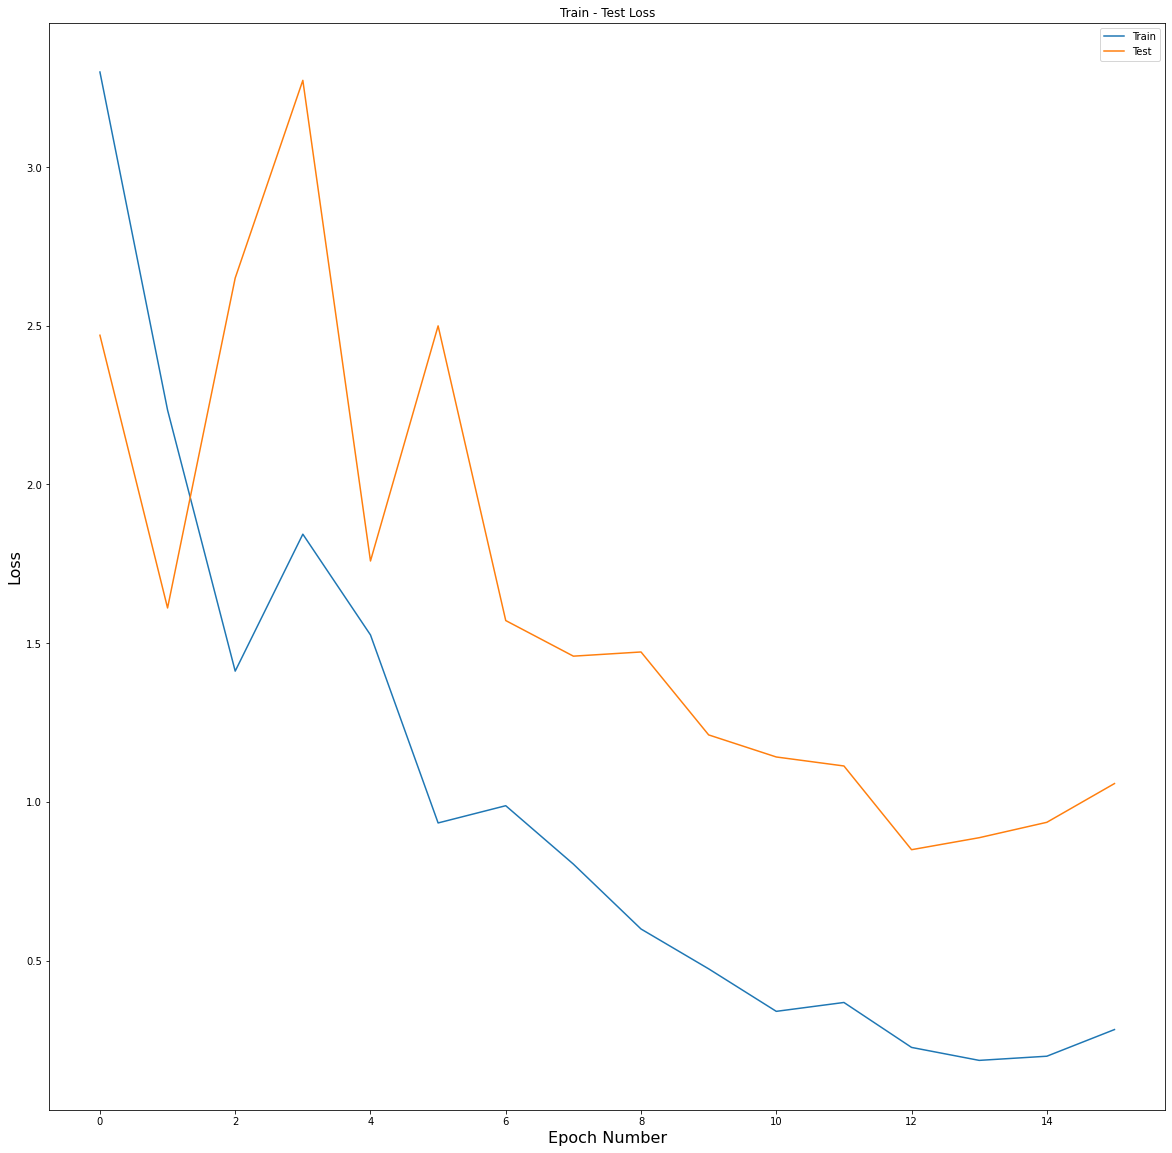

In [65]:
fig = plt.figure(figsize = (20,20))
plt.title("Train - Test Loss")
plt.plot(train_loss, label = "Train")
plt.plot(val_loss, label = "Test")
plt.xlabel("Epoch Number", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.legend(loc = "Best")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'Best'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


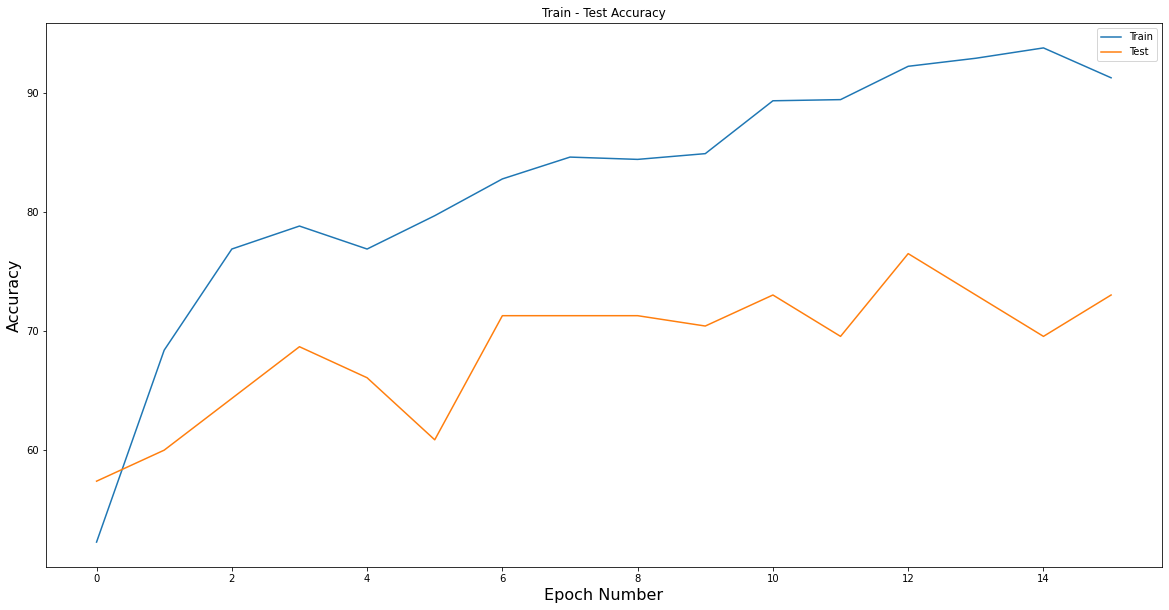

In [66]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Test Accuracy")
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Test')
plt.xlabel('Epoch Number', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='Best')

#Some Generic Questions

### Why Jupyter Notebooks/Google Colaboratory?

The reason behind that is these are interactive notebook and it is easy to implement. These can be easily transferred from one computer to another without causing not much need to change the original code.

### Why PyTorch?

PyTorch is one of the most advanced and open-source ML/DL frameworks available. It has computational graph support at runtime. It is flexible, faster, and provides optimizations. It has support for GPU and CPU. Easy to debug using Pythons IDE and debugging tools. So, using Pytorch is better. Tensorflow can be used but some of its functions are deprecated as compared to PyTorch


### How can we further imporve the accuracy of this model?

Improving the accuracy of the model is not that feasible once we reach a certain threshold. It becomes computationally expensive to do anything to improve the perfomance. I have run this model on all 3 system architectures provided by Google - CPU, GPU and TPU and all of them gove similar results.
Usually this model can be improved by adding more layers in the neural network either ConvNet layer or Linear Layer, increasing the number of epochs, or by getting more data.